

---



---

# Binary classification


---



---


Binary classification is a machine learning task where the goal is to categorize input data into one of two distinct classes or categories.

In this notebook, we aim to conduct a binary classification task using the MNIST dataset. We will employ the Stochastic Gradient Descent (SGD) classifier along with cross-validation techniques, including StratifiedKFold, to ensure robust model evaluation. Given the presence of imbalanced data, we will introduce a custom base estimator, the `Never5Classifier`, to serve as a baseline reference. Furthermore, we'll evaluate the models using academic-standard evaluation metrics such as `precision`, recall, F1 score, and ROC AUC score, providing comprehensive insights into their performance and generalization capabilities.

### **MNIST Dataset:**
The MNIST dataset is a large database of handwritten digits commonly used for training various image processing systems. It contains 70,000 images of handwritten digits from 0 to 9, making it a staple dataset for benchmarking classification algorithms.

![MNIST Sample](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)


#Setup


This code imports necessary libraries for data analysis and visualization, including scikit-learn, NumPy, os, and Matplotlib. It also sets up Matplotlib's default font sizes for axes labels and tick labels.

In [ ]:
# Import libraries
import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Establish a fixed random seed for consistent reproducibility in random processes
np.random.seed(42)


# Fetch the dataset

This code fetches the MNIST dataset using scikit-learn's `fetch_openml` function. It retrieves version 1 of the dataset and stores it in the `mnist` variable. Then, it prints the keys of the dataset to examine its contents.

In [ ]:
from sklearn.datasets import fetch_openml

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Print the keys of the dataset
print(mnist.keys())

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])



This code assigns the feature matrix to X and the target vector to y from the MNIST dataset loaded earlier. It then prints the shape of the feature matrix X.

In [ ]:

X, y = mnist["data"], mnist["target"]

# Print the shape of the feature matrix (X)
print(X.shape)

(70000, 784)


In [ ]:
# Print the shape of the target labels (y)
print(y.shape)

(70000,)


In [ ]:
# Calculate the product of 28 * 28
print(28 * 28)

784


This code selects a digit from the MNIST dataset, reshapes it into a 28x28 image, and displays it using Matplotlib with a binary color map (black and white). It then turns off axis labels, saves the plotted image as "some_digit_plot.png", and finally, shows the image.

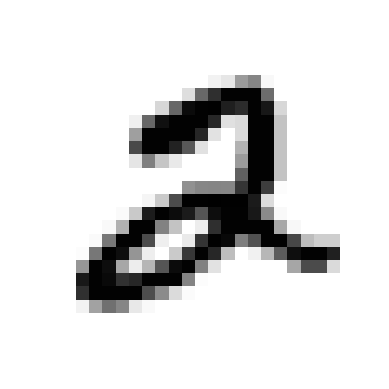

In [ ]:
# Select a digit from the MNIST dataset
some_digit = X[5]

# Reshape the flattened 1D array into a 2D array representing a 28x28 image
some_digit_image = some_digit.reshape(28, 28)

# Display the digit using Matplotlib with a binary color map (black and white)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)

# Turn off axis labels
plt.axis("off")

# Save the figure with the name "some_digit_plot.png"
plt.savefig("some_digit_plot.png")

# Show the plotted image
plt.show()

In [ ]:
# Display the label of the first digit in the MNIST dataset
print("Label of the first digit:", y[5])


Label of the first digit: 2


In [ ]:

# Convert the entire y array to unsigned integers
y = y.astype(np.uint8)

This code defines a function `plot_digit(data)` to plot a digit represented by a 1D array. It reshapes the array into a 28x28 image, plots the image using Matplotlib with a binary color map (black and white), and turns off axis labels.

In [ ]:
# Define a function to plot a digit
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")


This code defines a function plot_digits(instances, images_per_row=10, **options) to plot a grid of digits. It calculates the number of rows needed for the grid and pads the instances array with zeros to fill empty slots. Then, it reshapes the array to create a grid of images and combines axes to display the big image grid using Matplotlib with a binary color map (black and white). Finally, it turns off axis labels.

In [ ]:
# Define a function to plot a grid of digits
def plot_digits(instances, images_per_row=10, **options):
    # Size of each image (assuming 28x28 pixels for MNIST)
    size = 28

    # Calculate the number of rows needed for the grid
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Calculate the number of empty slots needed to fill the grid
    n_empty = n_rows * images_per_row - len(instances)

    # Pad the instances array with zeros to fill the empty slots
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array to create a grid of images
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). Use transpose() and reshape for this.
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    # Display the big image grid
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")


This code sets up the figure size, selects the first 100 images from the MNIST dataset, and then visualizes these images in a grid using the defined `plot_digits` function. Finally, it shows the plotted image grid.

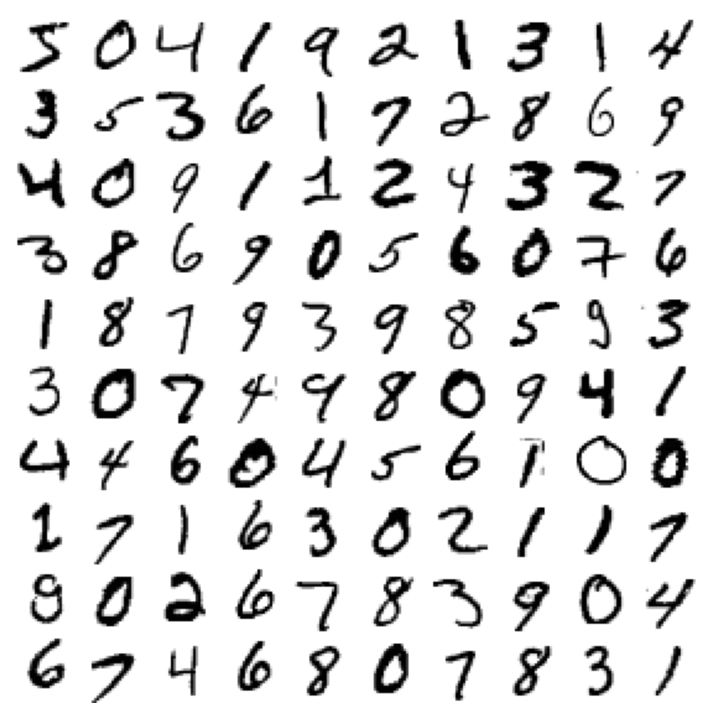

In [ ]:
# Set up the figure size
plt.figure(figsize=(9, 9))

# Select the first 100 images from the MNIST dataset
example_images = X[:100]

# Use the defined plot_digits function to visualize the images in a grid
plot_digits(example_images, images_per_row=10)

# Show the plotted image grid
plt.show()

#Split the dataset into training and testing sets

This code snippet splits the MNIST dataset into training and test sets. It assigns the first 60,000 instances to `X_train` and their corresponding labels to `y_train`, while the remaining instances are assigned to `X_test` and their labels to `y_test`.

In [ ]:
# Split the MNIST dataset into training and testing sets
# X_train: Training feature matrix (first 60,000 samples)
# X_test: Testing feature matrix (remaining samples)
# y_train: Training target labels (first 60,000 samples)
# y_test: Testing target labels (remaining samples)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

This code creates binary labels for the digit "5" in both the training and testing sets. It sets `y_train_5` to `True` for instances where the label is 5 and `False` otherwise. Similarly, it sets `y_test_5` to `True` for instances where the label is 5 and `False` otherwise. This prepares the data for a binary classification task where the objective is to classify whether a given digit is a 5 or not.

In [ ]:
# Create binary labels for the "5" digit in the training set
# y_train_5: True for instances where the label is 5, False otherwise
y_train_5 = (y_train == 5)

# Create binary labels for the "5" digit in the testing set
# y_test_5: True for instances where the label is 5, False otherwise
y_test_5 = (y_test == 5)

# Setup the models

## Stochastic Gradient Descent (SGD)

 **Stochastic Gradient Descent** is an optimization algorithm for training machine learning models.

`LogisticRegression` is a popular machine learning algorithm for binary classification tasks. Ay its core its a simple linear regression wrapped inside a logistic function with a slightly modified cost function. It uses the `solver` attribute to specify the algorithm used for optimization, such as 'liblinear', 'newton-cg', 'lbfgs', 'sag', and 'saga'.


For comprehensive information, refer to the [LogisticRegression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).


In [ ]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(solver='saga', random_state=42)
log_clf.fit(X_train, y_train_5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=42, solver='saga')

In [ ]:
predicted_label  = log_clf.predict([some_digit])
print(predicted_label)

[False]


This code imports the Stochastic Gradient Descent (SGD) classifier from scikit-learn and creates an instance of it named `sgd_clf`.
- Parameters like `max_iter`, `tol`, and `random_state` are specified during instantiation.
- `fit()` method is used to train the SGDClassifier on the training set, where `X_train` represents the training feature matrix and `y_train_5` contains binary labels indicating whether each instance is the digit "5" or not.

`SGDClassifier` stands for Stochastic Gradient Descent Classifier, a linear classifier that implements regularized linear models with stochastic gradient descent learning. It includes `max_iter`, specifying the maximum number of passes over the training data, and `tol`, the stopping criterion.

Learn more at the [SGDClassifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html).


In [ ]:
# Import the Stochastic Gradient Descent (SGD) classifier from scikit-learn
from sklearn.linear_model import SGDClassifier

# Create an instance of the SGDClassifier
# max_iter: Maximum number of epochs (passes through the training set)
# tol: Tolerance to declare convergence (stops training when the change is smaller than tol)
# random_state: Seed for reproducibility
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

# Train the SGDClassifier on the training set
# X_train: Training feature matrix
# y_train_5: Binary labels indicating whether each instance is the digit "5" or not
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

This code utilizes the trained SGD classifier (`sgd_clf`) to predict whether the digit represented by `some_digit` is the digit "5". The `predict()` method is applied to the single instance `some_digit`, returning `True` if the classifier predicts it as the digit "5" and `False` otherwise.

In [ ]:
# Use the trained classifier to predict whether 'some_digit' is the digit "5"
sgd_clf.predict([some_digit])

array([False])



---
---


# Performance Metrics

---

---





# Cross Valdition

**Cross-validation** is a technique used to evaluate the performance of machine learning models. It involves partitioning the dataset into subsets, training the model on some subsets, and evaluating it on others. This process is repeated multiple times to ensure robustness and estimate the model's performance accurately.


This code imports the necessary libraries for cross-validation from scikit-learn. It then performs cross-validation on the SGDClassifier (`sgd_clf`) using accuracy as the scoring metric. The `cross_val_score()` function is applied with parameters `X_train` as the training feature matrix, `y_train_5` as the binary labels, `cv=3` for 3-fold cross-validation, and `scoring="accuracy"` to evaluate the model's performance based on accuracy.

In [ ]:
# Import libraries for cross-validation
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the SGDClassifier using accuracy as the scoring metric
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

# StratifiedKFold
StratifiedKFold is a variant of K-Fold cross-validation where each fold preserves the percentage of samples for each class. It ensures that the class distribution is maintained in both the training and testing sets, making it particularly useful for classification tasks with imbalanced datasets.

This code imports libraries for StratifiedKFold and creates a StratifiedKFold object named `skfolds` for manual cross-validation. It sets the number of splits to 3, shuffles the data, and uses a fixed random state for reproducibility.

![Stratified Sampling Example](https://upload.wikimedia.org/wikipedia/commons/d/df/Stratisfied_Random_Sampling.jpg)

It then performs manual cross-validation using StratifiedKFold. For each fold, it clones the SGDClassifier (`sgd_clf`) to have a fresh model, splits the data into training and testing sets, trains the clone classifier on the training folds, predicts on the testing fold, calculates the accuracy, and displays the accuracy for each fold. This manual cross-validation process allows evaluating the model's performance across different folds of the training data.

In [ ]:
# Import libraries for StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Create StratifiedKFold object for manual cross-validation
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform manual cross-validation using StratifiedKFold
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # Clone the classifier to have a fresh model for each fold
    clone_clf = clone(sgd_clf)

    # Split the training and testing sets for the current fold
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # Train the clone classifier on the training folds
    clone_clf.fit(X_train_folds, y_train_folds)

    # Predict on the testing fold and calculate the accuracy
    y_pred = clone_clf.predict(X_test_fold)
    accuracy = sum(y_pred == y_test_fold) / len(y_pred)

    # Display the accuracy for the current fold
    print("Fold Accuracy:", accuracy)

Fold Accuracy: 0.9669
Fold Accuracy: 0.91625
Fold Accuracy: 0.96785


# Base Estimator


The BaseEstimator class in scikit-learn serves as the foundation for all estimators, providing a consistent interface for fitting models to data, making predictions, and handling parameters. It ensures uniformity across different models and simplifies the process of working with machine learning algorithms.

This code snippet imports the `BaseEstimator` class from scikit-learn and defines a custom classifier class named `Never5Classifier`. This classifier is designed to always predict non-"5" for any input data.

The `fit()` method of this class does nothing as no training is needed for this classifier. It simply passes without any operation.

The `predict()` method returns an array of zeros, indicating a prediction of non-"5" for all instances in the input data `X`. The dtype is set to boolean (`dtype=bool`).

In [ ]:

# Import the BaseEstimator class from scikit-learn
from sklearn.base import BaseEstimator

# Define a custom classifier class that always predicts non-"5"
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        # No training is needed for this classifier, hence the empty fit method
        pass

    def predict(self, X):
        # Return an array of zeros indicating a prediction of non-"5" for all instances
        return np.zeros((len(X), 1), dtype=bool)

# Never5Classifier
The Never5Classifier is a simple classifier that always predicts the same class, typically the negative class. It serves as a baseline for evaluating more complex models and helps assess whether a model is actually learning meaningful patterns from the data.









This code creates an instance of the `Never5Classifier` named `never_5_clf`. It then performs cross-validation on the `Never5Classifier` using accuracy as the scoring metric. The `cross_val_score()` function is applied with parameters `X_train` as the training feature matrix, `y_train_5` as the binary labels, `cv=3` for 3-fold cross-validation, and `scoring="accuracy"` to evaluate the model's performance based on accuracy.

In [ ]:
# Create an instance of the Never5Classifier
never_5_clf = Never5Classifier()

# Perform cross-validation on the Never5Classifier using accuracy as the scoring metric
cross_val_scores_never_5 = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


# Confusion Matrix
A **confusion matrix** is a table used in classification to evaluate the performance of a model. It shows the counts of true positive, true negative, false positive, and false negative predictions.

![Confusion Matrix](https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png?w=431&h=243)


This code snippet imports the `cross_val_predict` function from scikit-learn. It then uses `cross_val_predict` to obtain cross-validated predictions for the training set. Predictions are made using the SGD classifier (`sgd_clf`) on each fold of the cross-validation, and the resulting predictions are stored in the `y_train_pred` variable.

In [ ]:
# Import the cross_val_predict function from scikit-learn
from sklearn.model_selection import cross_val_predict

# Use cross_val_predict to obtain cross-validated predictions for the training set
# Predictions are made using the SGD classifier on each fold of the cross-validation
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

This code imports the `confusion_matrix` function from scikit-learn. It then computes the confusion matrix for binary classification using the `y_train_5` as the true labels (actual class) and `y_train_pred` as the predicted labels (predicted class). The resulting confusion matrix is stored in the variable `confusion_mat`.

In [ ]:
# Import the confusion_matrix function from scikit-learn
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix for binary classification
# y_train_5: True labels (actual class)
# y_train_pred: Predicted labels (predicted class)
confusion_mat = confusion_matrix(y_train_5, y_train_pred)

This code segment assigns the true labels `y_train_5` to `y_train_perfect_predictions`, assuming perfect predictions. Then, it computes the confusion matrix for these perfect predictions using the `confusion_matrix` function from scikit-learn. The resulting confusion matrix represents the scenario where the predicted labels perfectly match the true labels.

In [ ]:
# Assign the true labels to y_train_perfect_predictions, pretending perfect predictions
y_train_perfect_predictions = y_train_5

# Compute the confusion matrix for the perfect predictions
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# Precision and Recall


Precision and recall are two key evaluation metrics for binary classification tasks:

1. **Precision**: Precision measures the accuracy of positive predictions. It is the ratio of true positives to the sum of true positives and false positives.

2. **Recall**: Recall measures the ability of the model to capture all positive instances. It is the ratio of true positives to the sum of true positives and false negatives.

This code segment imports the `precision_score` and `recall_score` functions from scikit-learn. Then, it calculates the precision score for binary classification using the `precision_score` function. The true labels (`y_train_5`) represent the actual class, and the predicted labels (`y_train_pred`) represent the predicted class.

In [ ]:
# Import the precision_score and recall_score function from scikit-learn
from sklearn.metrics import precision_score, recall_score

# Calculate precision score for binary classification
# y_train_5: True labels (actual class)
# y_train_pred: Predicted labels (predicted class)
precision_score(y_train_5, y_train_pred)


0.8370879772350012

This code computes the confusion matrix for binary classification and stores it in the variable `cm`. Then, it calculates the precision manually using values from the confusion matrix. Precision is defined as the ratio of true positives (TP) to the sum of false positives (FP) and true positives (TP). In the confusion matrix `cm`, `cm[1, 1]` represents true positives (TP), `cm[0, 1]` represents false positives (FP), and the precision is computed as `cm[1, 1] / (cm[0, 1] + cm[1, 1])`.

In [ ]:
# Compute the confusion matrix for binary classification
cm = confusion_matrix(y_train_5, y_train_pred)

# Calculate precision manually using values from the confusion matrix
# Precision is defined as TP / (FP + TP), where TP is true positives and FP is false positives
cm[1, 1] / (cm[0, 1] + cm[1, 1])


0.8370879772350012

This code calculates the recall score for binary classification using the `recall_score` function from scikit-learn. The true labels (`y_train_5`) represent the actual class, and the predicted labels (`y_train_pred`) represent the predicted class.

In [ ]:
# Calculate recall score for binary classification
# y_train_5: True labels (actual class)
# y_train_pred: Predicted labels (predicted class)
recall_score(y_train_5, y_train_pred)


0.6511713705958311

This code calculates the recall for the positive class (class "5") using values from the confusion matrix. Recall, also known as sensitivity, is the ratio of true positives to the sum of true positives and false negatives. In the confusion matrix `cm`, `cm[1, 1]` represents true positives (instances correctly predicted as positive), `cm[1, 0]` represents false negatives (instances incorrectly predicted as negative), and the recall is computed as `cm[1, 1] / (cm[1, 0] + cm[1, 1])`.

In [ ]:
# Calculate recall for the positive class (class "5") using values from the confusion matrix
# Recall is the ratio of true positives to the sum of true positives and false negatives
# cm[1, 1]: True Positives (instances correctly predicted as positive)
# cm[1, 0]: False Negatives (instances incorrectly predicted as negative)
# cm[1, 1] + cm[1, 0]: Total number of actual positive instances
cm[1, 1] / (cm[1, 0] + cm[1, 1])


0.6511713705958311

This code imports the `f1_score` function from scikit-learn. Then, it calculates the F1 score for binary classification using the `f1_score` function. The true labels (`y_train_5`) represent the actual class, and the predicted labels (`y_train_pred`) represent the predicted class.

In [ ]:
# Import the f1_score function from scikit-learn
from sklearn.metrics import f1_score

# Calculate F1 score for binary classification
# y_train_5: True labels (actual class)
# y_train_pred: Predicted labels (predicted class)
f1 = f1_score(y_train_5, y_train_pred)


This code calculates the balanced F1 score using values from the confusion matrix. The balanced F1 score provides a balance between precision and recall, considering both classes. In the confusion matrix `cm`, `cm[1, 1]` represents true positives (instances correctly predicted as positive), `cm[1, 0]` represents false negatives (instances incorrectly predicted as negative), and `cm[0, 1]` represents false positives (instances incorrectly predicted as positive). The balanced F1 score is computed as:

Balanced F1 score=

2×(Precision×Recall)/Precision+Recall
​




This calculation provides a single metric that considers both precision and recall for evaluating classifier performance.

In [ ]:
# Calculate the balanced F1 score using values from the confusion matrix
# Balanced F1 score provides a balance between precision and recall, considering both classes
# cm[1, 1]: True Positives (instances correctly predicted as positive)
# cm[1, 0]: False Negatives (instances incorrectly predicted as negative)
# cm[0, 1]: False Positives (instances incorrectly predicted as positive)
# Balanced F1 score = 2 * (Precision * Recall) / (Precision + Recall)
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)


0.7325171197343847

# Precision/Recall Trade-off

The `decision_function` method is used to obtain decision scores for a specific instance `some_digit` using the trained SGD classifier (`sgd_clf`). The decision scores represent the signed distances of the samples to the separating hyperplane. The result is displayed, showing the decision score for the given instance.

In [ ]:
# Use the decision_function method to obtain decision scores for a specific instance (some_digit)
y_scores = sgd_clf.decision_function([some_digit])

# Display the decision scores
y_scores

array([-3908.27576291])

Setting a threshold of 0 for decision scores means that any instance with a decision score greater than 0 will be classified as positive (in this case, as the digit "5"). The result is displayed, showing whether the specific instance `some_digit` is predicted as the digit "5" based on this threshold.

In [ ]:
# Set a threshold for decision scores
threshold = 0

# Make binary predictions based on the threshold
y_some_digit_pred = (y_scores > threshold)

# Display the binary predictions for the specific instance (some_digit)
y_some_digit_pred

array([False])

The code sets a new threshold for decision scores at 8000 and then makes binary predictions based on this threshold. If the decision score for a particular instance is greater than 8000, it predicts the positive class (True), otherwise, it predicts the negative class (False). Finally, it displays the binary predictions.

In [ ]:
# Set a new threshold for decision scores
threshold = 8000

# Make binary predictions based on the new threshold
y_some_digit_pred = (y_scores > threshold)

# Display the binary predictions
y_some_digit_pred

array([False])

This code utilizes the `cross_val_predict` function to obtain cross-validated decision scores for the training set. These decision scores are acquired using the SGD classifier on each fold of the cross-validation process. The parameter `method="decision_function"` specifies that the decision scores are obtained using the `decision_function` method of the classifier.

In [ ]:
# Use cross_val_predict to obtain cross-validated decision scores for the training set
# Decision scores are obtained using the SGD classifier on each fold of the cross-validation
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


This code imports the `precision_recall_curve` function from scikit-learn's `metrics` module. Then, it computes precision-recall pairs for different probability thresholds using the `precision_recall_curve` function. The `y_train_5` contains the true labels (actual class), and `y_scores` contains the decision scores or predicted probabilities.

In [ ]:
# Import the precision_recall_curve function from scikit-learn
from sklearn.metrics import precision_recall_curve

# Compute precision-recall pairs for different probability thresholds
# y_train_5: True labels (actual class)
# y_scores: Decision scores obtained from cross-validated predictions
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


This code defines a function `plot_precision_recall_vs_threshold` to plot precision and recall as functions of the threshold. It then computes the recall at 90% precision and finds the threshold corresponding to 90% precision. Finally, it plots the precision-recall vs. threshold curve and highlights the 90% precision threshold on the plot.

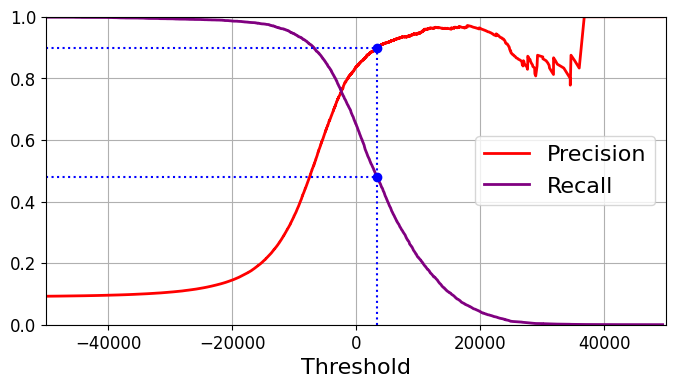

In [ ]:
# Function to plot precision and recall as functions of the threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "red", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "purple", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

# Compute recall at 90% precision
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

# Find the threshold corresponding to 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# Plot the precision-recall vs. threshold curve and highlight the 90% precision threshold
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "b:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "b:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "b:")
plt.plot([threshold_90_precision], [0.9], "bo")
plt.plot([threshold_90_precision], [recall_90_precision], "bo")
plt.show()


The expression `(y_train_pred == (y_scores > 0)).all()` checks if all elements in the boolean array resulting from the comparison between the predicted labels `y_train_pred` and the comparison between decision scores and 0 `(y_scores > 0)` are True. If the result is True, it indicates that the binary predictions are consistent with the decision scores being greater than 0 for all instances.

In [ ]:
# Check if all elements in the boolean array resulting from the comparison are True
# This verifies whether binary predictions are consistent with decision scores being greater than 0
(y_train_pred == (y_scores > 0)).all()

True

The threshold for achieving 90% precision can be found by identifying the threshold value in the `thresholds` array that corresponds to the index where the precision is greater than or equal to 0.90. This is done using the `np.argmax` function. Let's calculate it.

In [ ]:
# Find the threshold for 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

The precision score for the predictions made using the threshold for achieving 90% precision can be calculated using the `precision_score` function from scikit-learn. Let's compute it.

In [ ]:

# Make predictions based on the 90% precision threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

# Calculate precision scores for the predictions
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

The recall score for the predictions made using the threshold for achieving 90% precision can be calculated using the `recall_score` function from scikit-learn. Let's compute it.

In [ ]:
# Calculate recall scores for the predictions

recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# The ROC Curve


The **ROC curve** is a graphical representation of the trade-off between true positive rate (sensitivity) and false positive rate across different threshold settings for a binary classifier. It provides a comprehensive view of the classifier's performance.

This code imports the `roc_curve` function from scikit-learn's `metrics` module. Then, it calculates the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC (Receiver Operating Characteristic) curve using the `roc_curve` function. The `y_train_5` contains the true labels (actual class), and `y_scores` contains the decision scores or predicted probabilities (scores used to compute the ROC curve).

In [ ]:

# Import roc_curve function from sklearn
from sklearn.metrics import roc_curve

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


This code defines a function `plot_roc_curve` to plot the ROC (Receiver Operating Characteristic) curve. It then creates a figure for the ROC curve plot and calls the `plot_roc_curve` function to plot the ROC curve. Additionally, it finds the False Positive Rate (FPR) corresponding to the recall threshold of 90% and highlights the point on the ROC curve for 90% recall. Finally, it displays the plot.

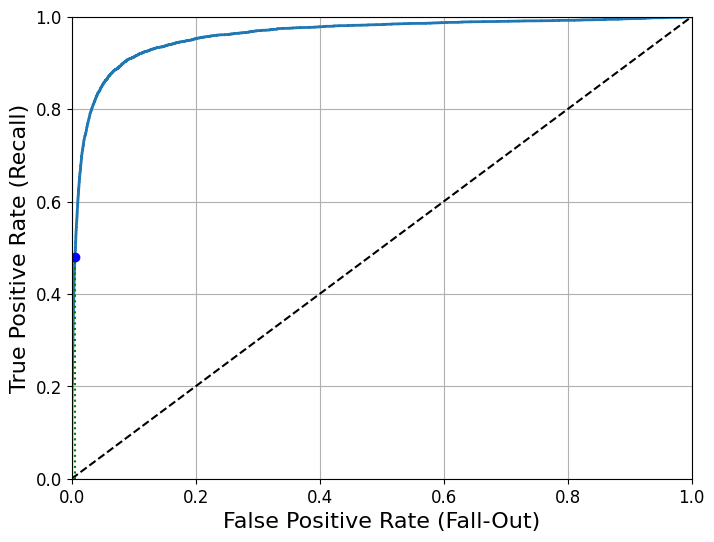

In [ ]:

# Function to plot the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.axis([0, 1, 0, 1])  # Set axis limits
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
# Create a figure for the ROC curve plot
plt.figure(figsize=(8, 6))
# Call the function to plot the ROC curve
plot_roc_curve(fpr, tpr)

# Find the FPR corresponding to the recall threshold of 90%
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

# Highlight the point on the ROC curve for 90% recall
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "g:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "g:")
plt.plot([fpr_90], [recall_90_precision], "bo")

# Display the plot
plt.show()


This code calculates the ROC AUC (Receiver Operating Characteristic Area Under the Curve) score using the `roc_auc_score` function from scikit-learn. The `y_train_5` contains the true labels (actual class), and `y_scores` contains the decision scores or predicted probabilities (scores used to compute ROC curve).

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate the ROC AUC score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616